# 서울시 반려동물 현황

## 서울시 자치구별 반려동물 등록 현황

In [1]:
from database.Database import Database
import pandas as pd
import matplotlib.pyplot as plt
import koreanize_matplotlib
import folium
import json

In [2]:
db = Database(
    host = "database-2.c3iym8yog7ht.ap-northeast-2.rds.amazonaws.com",
    port = 3306,
    user = "pethub",
    password = "addinedu5",
    database = "pethub"
)

## 자치구별 입양형태 분석
* DB에서 지역구 정보 로드

In [3]:
sql = "SELECT region FROM region_list"
result = db.selectData(sql)

region_list = [row[0] for row in result]
print(region_list)

['종로구', '중구', '용산구', '성동구', '광진구', '동대문구', '중랑구', '성북구', '강북구', '도봉구', '노원구', '은평구', '서대문구', '마포구', '양천구', '강서구', '구로구', '금천구', '영등포구', '동작구', '관악구', '서초구', '강남구', '송파구', '강동구']


* 자치구별 입양형태 테이블에서 가져온 지역구 이름으로 지역별 입양형태를 가져옴

In [7]:
result = []
for row in region_list:
    query = """
    select rl.region, rpa.sale, rpa.friend, rpa.abandoned, rpa.internet 
    from region_pet_acquis rpa, region_list rl 
    where rl.id = rpa.region_id and rl.region = %s
    """
    result.append(db.selectData(query, (row,), "one"))

In [8]:
result

[('종로구', 23.5, 58.9, 12.4, 0.3),
 ('중구', 28.1, 62.6, 7.0, 0.0),
 ('용산구', 15.5, 52.5, 32.0, 0.0),
 ('성동구', 27.9, 65.0, 3.0, 0.8),
 ('광진구', 38.5, 44.3, 15.1, 0.3),
 ('동대문구', 44.3, 40.7, 5.5, 6.0),
 ('중랑구', 16.1, 62.4, 14.0, 6.3),
 ('성북구', 38.3, 57.7, 3.4, 0.6),
 ('강북구', 26.4, 54.0, 15.5, 0.3),
 ('도봉구', 20.6, 73.9, 5.5, 0.0),
 ('노원구', 23.8, 57.5, 15.7, 0.6),
 ('은평구', 28.5, 55.9, 13.7, 0.8),
 ('서대문구', 19.1, 62.0, 14.4, 0.0),
 ('마포구', 36.1, 48.1, 8.2, 4.3),
 ('양천구', 24.5, 61.3, 7.7, 6.5),
 ('강서구', 31.4, 50.0, 6.1, 1.9),
 ('구로구', 11.8, 65.9, 13.8, 2.1),
 ('금천구', 12.2, 79.8, 8.1, 0.0),
 ('영등포구', 14.8, 66.8, 11.2, 5.8),
 ('동작구', 18.3, 69.3, 6.2, 2.2),
 ('관악구', 21.7, 52.8, 20.9, 4.2),
 ('서초구', 21.5, 62.2, 5.3, 0.2),
 ('강남구', 26.2, 54.5, 18.6, 0.2),
 ('송파구', 13.2, 60.8, 22.1, 0.7),
 ('강동구', 28.9, 59.4, 10.2, 0.6)]

* 자치구별 입양 형태를 불러와 데이터프레임 구성

In [9]:
region_pet_acquis_df = pd.DataFrame(result, columns=["자치구", "동물판매업", "지인입양", "유기동물입양", "인터넷구매"])
region_pet_acquis_df

,자치구,동물판매업,지인입양,유기동물입양,인터넷구매
0,종로구,23.5,58.9,12.4,0.3
1,중구,28.1,62.6,7.0,0.0
2,용산구,15.5,52.5,32.0,0.0
3,성동구,27.9,65.0,3.0,0.8
4,광진구,38.5,44.3,15.1,0.3
5,동대문구,44.3,40.7,5.5,6.0
6,중랑구,16.1,62.4,14.0,6.3
7,성북구,38.3,57.7,3.4,0.6
8,강북구,26.4,54.0,15.5,0.3
9,도봉구,20.6,73.9,5.5,0.0


* subplots를 이용해 2 x 2 형태의 pie 그래프를 그려 각 입양형태별 상위 5개구를 확인

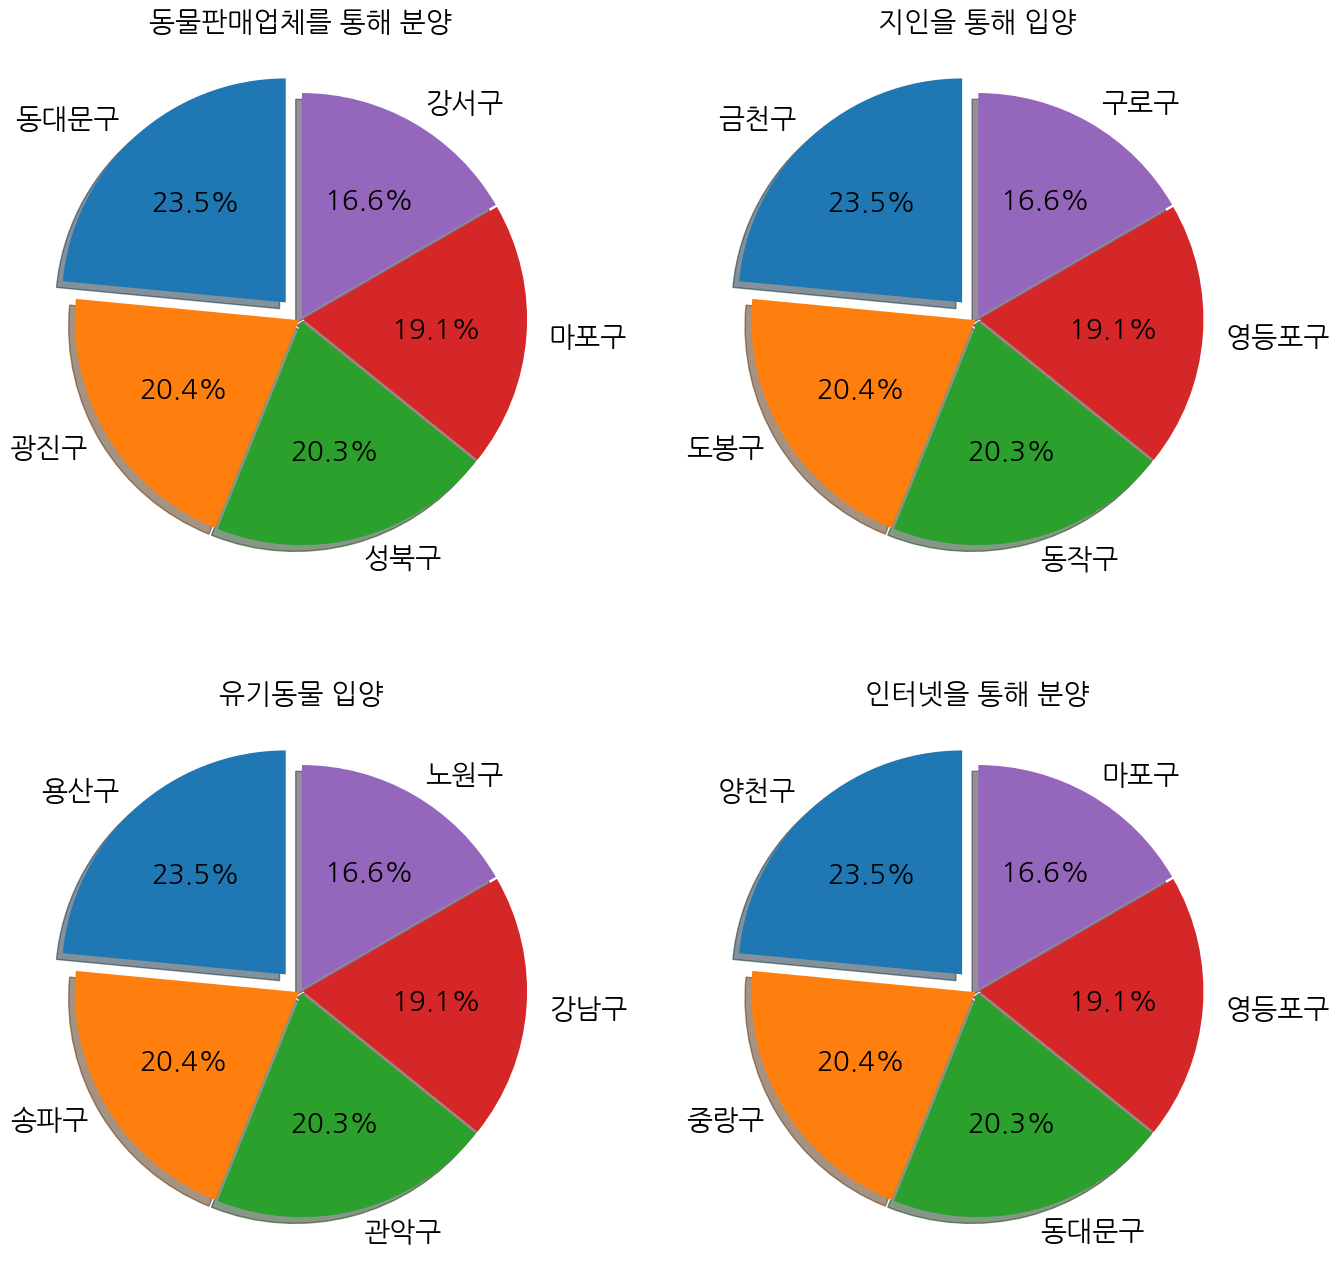

In [10]:
fig, ax = plt.subplots(2, 2, figsize=(16, 16))

top5_shop = region_pet_acquis_df.sort_values(by="동물판매업", ascending=False).head()
ax[0,0].pie(top5_shop["동물판매업"], labels=top5_shop["자치구"], autopct="%1.1f%%", shadow=True, \
            explode=[0.1, 0.01, 0.01, 0.01, 0.01], startangle=90,  textprops={'fontsize': 20})
ax[0,0].set_title("동물판매업체를 통해 분양", fontsize=20)

top5_friend = region_pet_acquis_df.sort_values(by="지인입양", ascending=False).head()
ax[0,1].pie(top5_shop["동물판매업"], labels=top5_friend["자치구"], autopct="%1.1f%%", shadow=True, \
            explode=[0.1, 0.01, 0.01, 0.01, 0.01], startangle=90, textprops={'fontsize': 20})
ax[0,1].set_title("지인을 통해 입양", fontsize=20)

top5_abandonment = region_pet_acquis_df.sort_values(by="유기동물입양", ascending=False).head()
ax[1,0].pie(top5_shop["동물판매업"], labels=top5_abandonment["자치구"], autopct="%1.1f%%", shadow=True, \
            explode=[0.1, 0.01, 0.01, 0.01, 0.01], startangle=90, textprops={'fontsize': 20})
ax[1,0].set_title("유기동물 입양", fontsize=20)

top5_internet = region_pet_acquis_df.sort_values(by="인터넷구매", ascending=False).head()
ax[1,1].pie(top5_shop["동물판매업"], labels=top5_internet["자치구"], autopct="%1.1f%%", shadow=True, \
            explode=[0.1, 0.01, 0.01, 0.01, 0.01], startangle=90, textprops={'fontsize': 20})
ax[1,1].set_title("인터넷을 통해 분양", fontsize=20)

plt.show()

## 거주 형태별 반려동물을 키우는 비율
* DB에서 데이터를 꺼내와 데이터프레임 구성

In [11]:
query = "select * from housing_type"
housing_type = pd.DataFrame(db.selectData(query), columns=["형태", "비율"]).sort_values(by="비율", ascending=False)
housing_type

,형태,비율
1,아파트,21.0
2,다세대주택,17.4
3,연립/기타,17.4
0,단독주택,17.1


* pie 그래프를 통해 거주형태별 반려동물을 키우는 비율을 확인

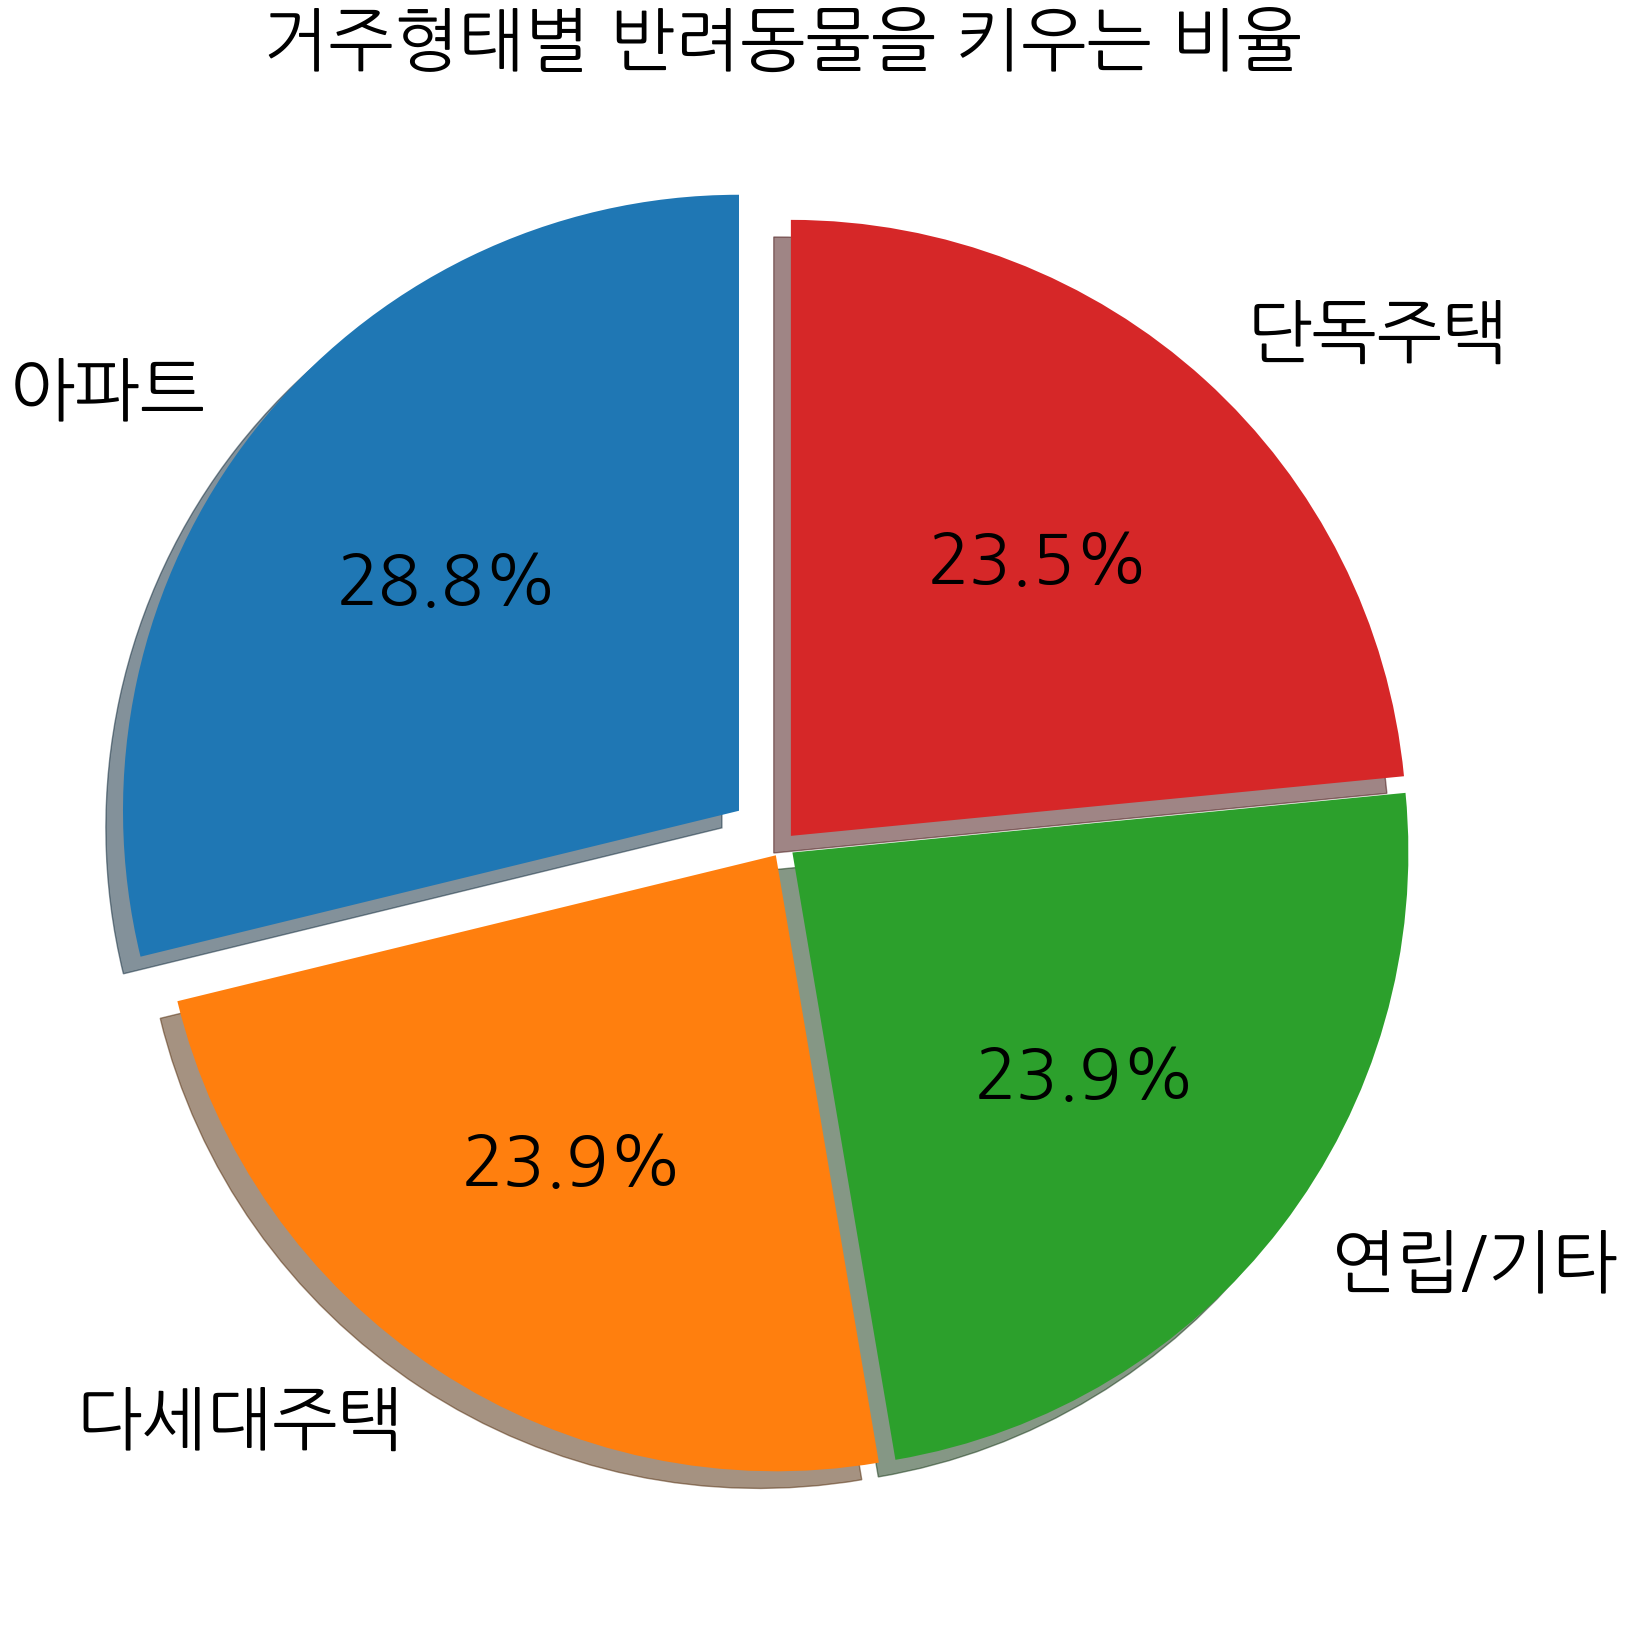

In [12]:
plt.figure(figsize=(20, 20))
plt.pie(housing_type["비율"], labels=housing_type["형태"], autopct="%1.1f%%", startangle=90, shadow=True, \
        explode=[0.09, 0.02, 0.02, 0.02], textprops={'fontsize': 50})
plt.title("거주형태별 반려동물을 키우는 비율", fontsize=50)
plt.show()

## 가구원수별 반려동물을 키우는 비율
* DB에서 데이터를 꺼내와 데이터프레임 구성

In [13]:
query = "select * from house_member"
house_member = pd.DataFrame(db.selectData(query), columns=["형태", "비율"]).sort_values(by="비율", ascending=False)
house_member

,형태,비율
1,2인,20.6
3,4인 이상,20.4
2,3인,19.1
0,1인,16.9


* pie 그래프를 통해 가구원수별 반려동물을 키우는 비율을 확인

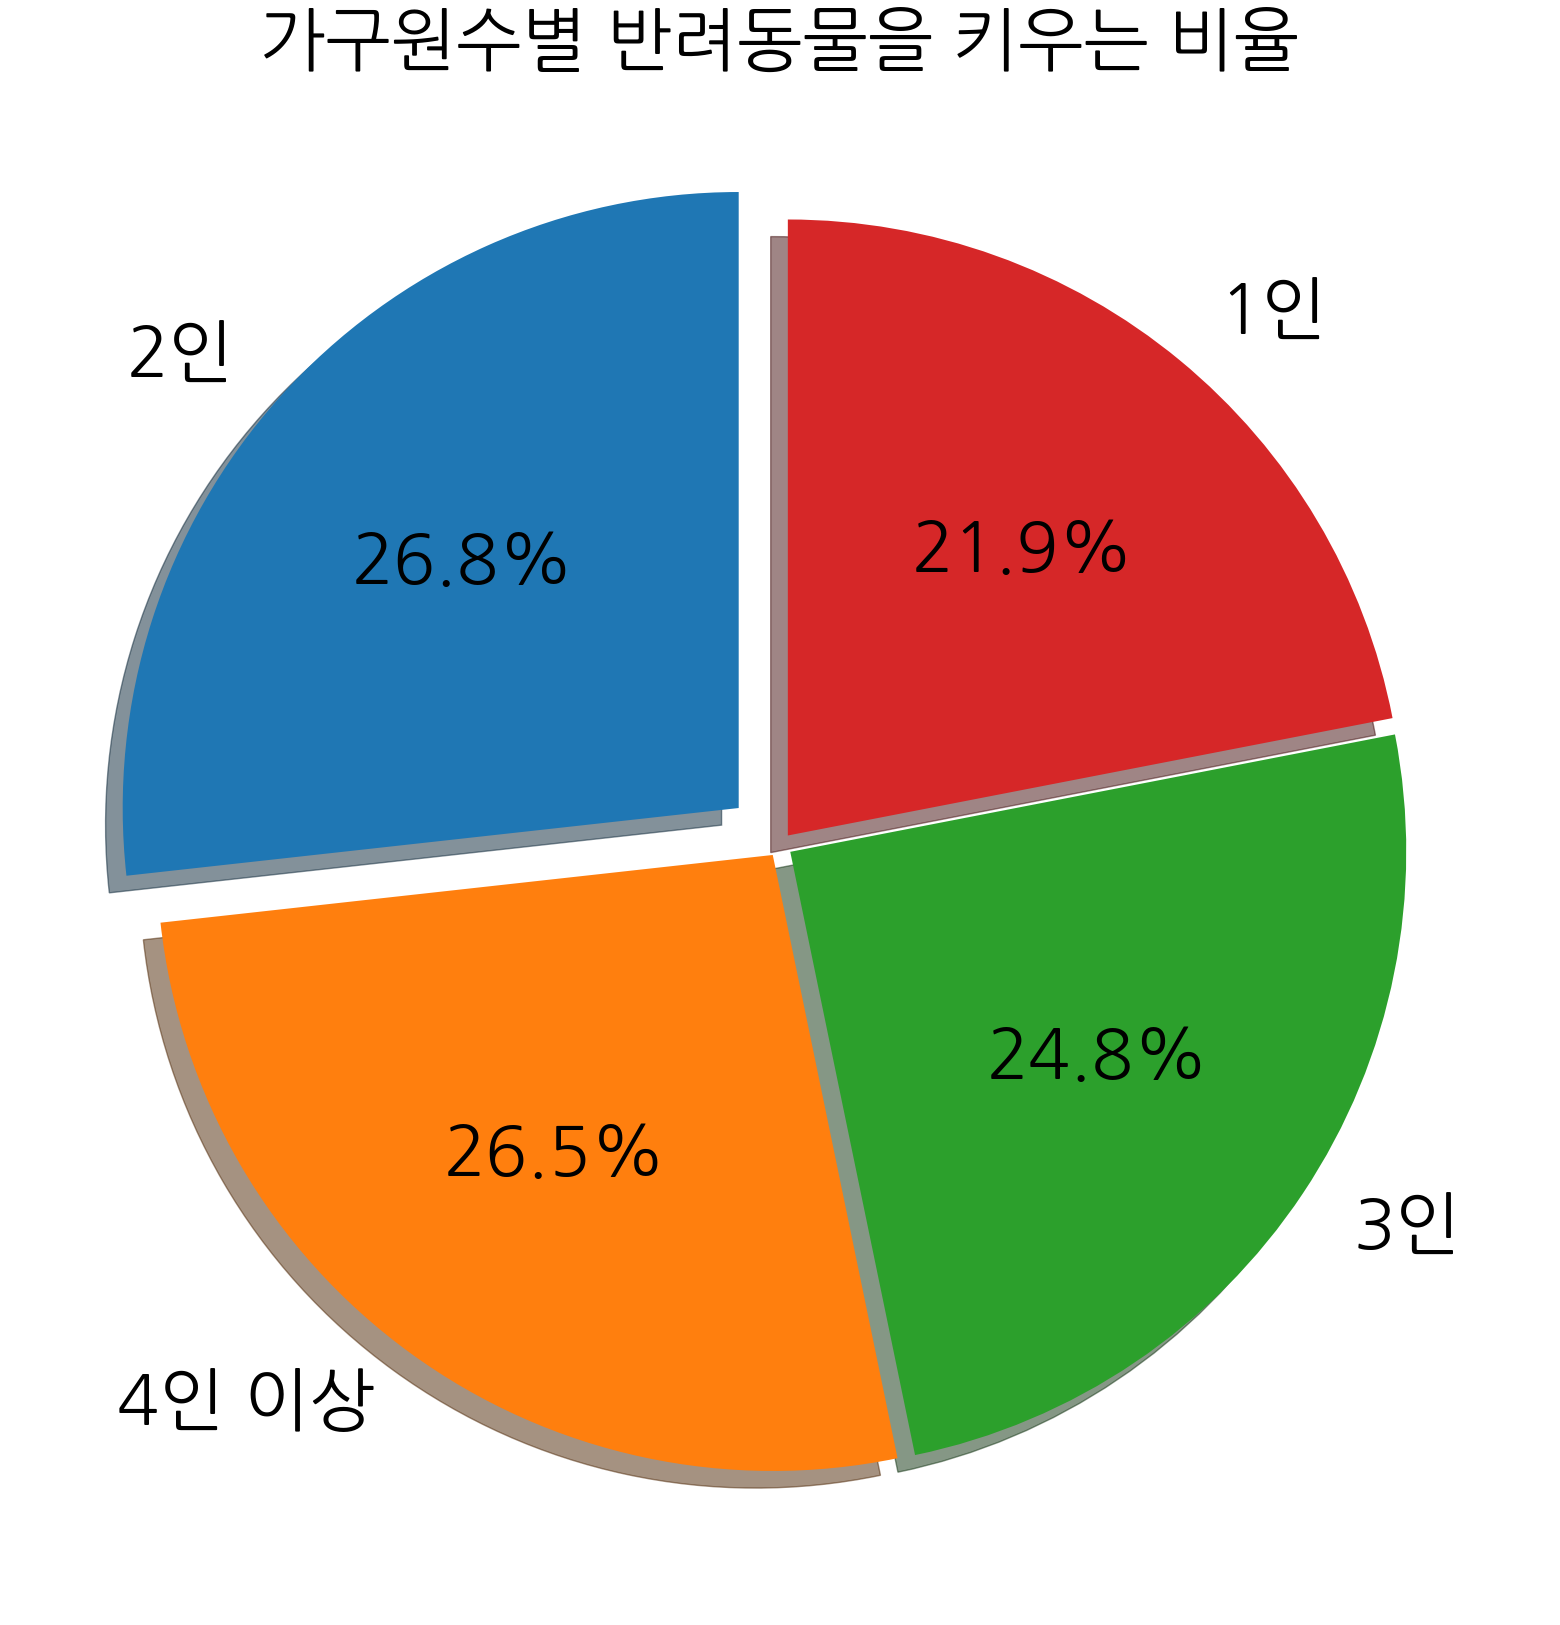

In [14]:
plt.figure(figsize=(20, 20))
plt.pie(house_member["비율"], labels=house_member["형태"], explode=[0.09, 0.02, 0.02, 0.02], \
        startangle=90, shadow=True, autopct="%1.1f%%", textprops={'fontsize': 50})
plt.title("가구원수별 반려동물을 키우는 비율", fontsize=50)
plt.show()

## 소득구간별 반려동물을 키우는 비율
* DB에서 데이터를 꺼내와 데이터프레임 구

In [15]:
query = "select * from income_bracket"
income_bracket = pd.DataFrame(db.selectData(query), columns=["형태", "비율"]).sort_values(by="비율", ascending=False)
income_bracket

,형태,비율
4,800만원 이상,29.9
3,800만원 미만,23.3
2,600만원 미만,18.9
1,400만원 미만,17.1
0,200만원 미만,12.5


* pie 그래프를 통해 소득구간별 반려동물을 키우는 비율을 확인

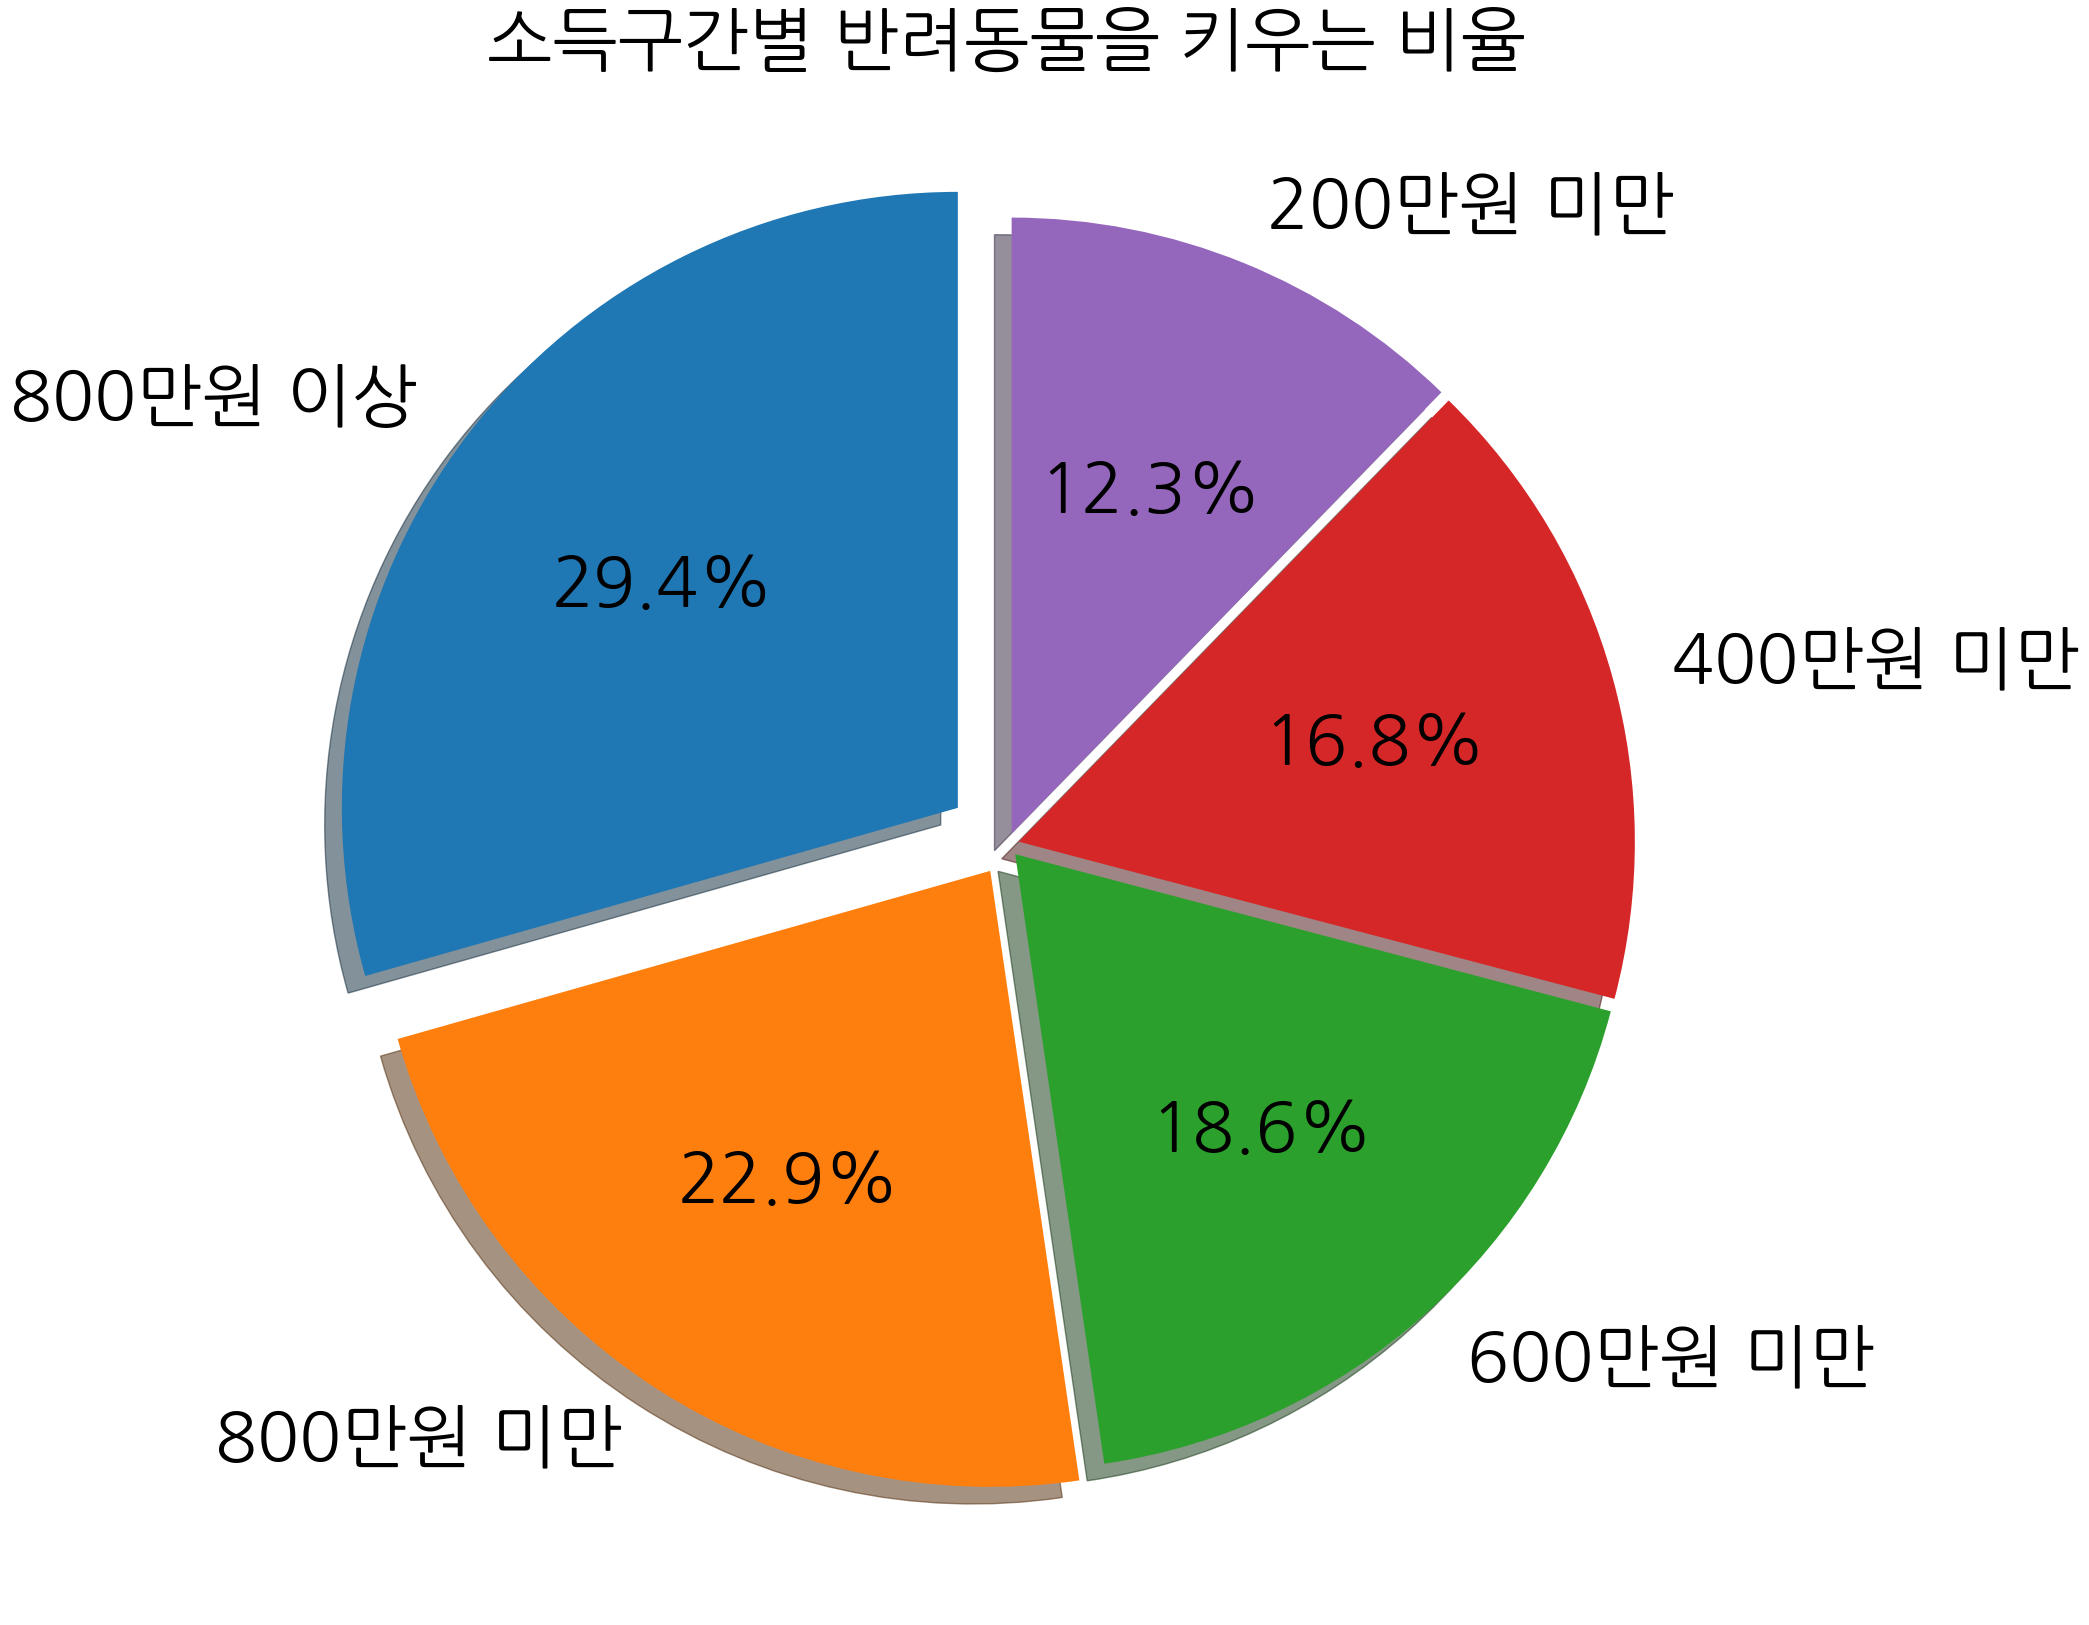

In [16]:
plt.figure(figsize=(20, 20))
plt.pie(income_bracket["비율"], labels=income_bracket["형태"], explode=[0.1, 0.05, 0.02, 0.02, 0.02], \
        startangle=90, shadow=True, autopct="%1.1f%%", textprops={'fontsize': 50})
plt.title("소득구간별 반려동물을 키우는 비율", fontsize=50)
plt.show()

## 점유형태별 반려동물을 키우는 비율
* DB에서 데이터를 꺼내와 데이터프레임 구성

In [17]:
query = "select * from property_type"
property_type = pd.DataFrame(db.selectData(query), columns=["형태", "비율"]).sort_values(by="비율", ascending=False)
property_type

,형태,비율
0,자가,20.7
1,전세,18.2
2,월세/기타,17.0


* pie 그래프를 통해 점유형태별 반려동물을 키우는 비율을 확이

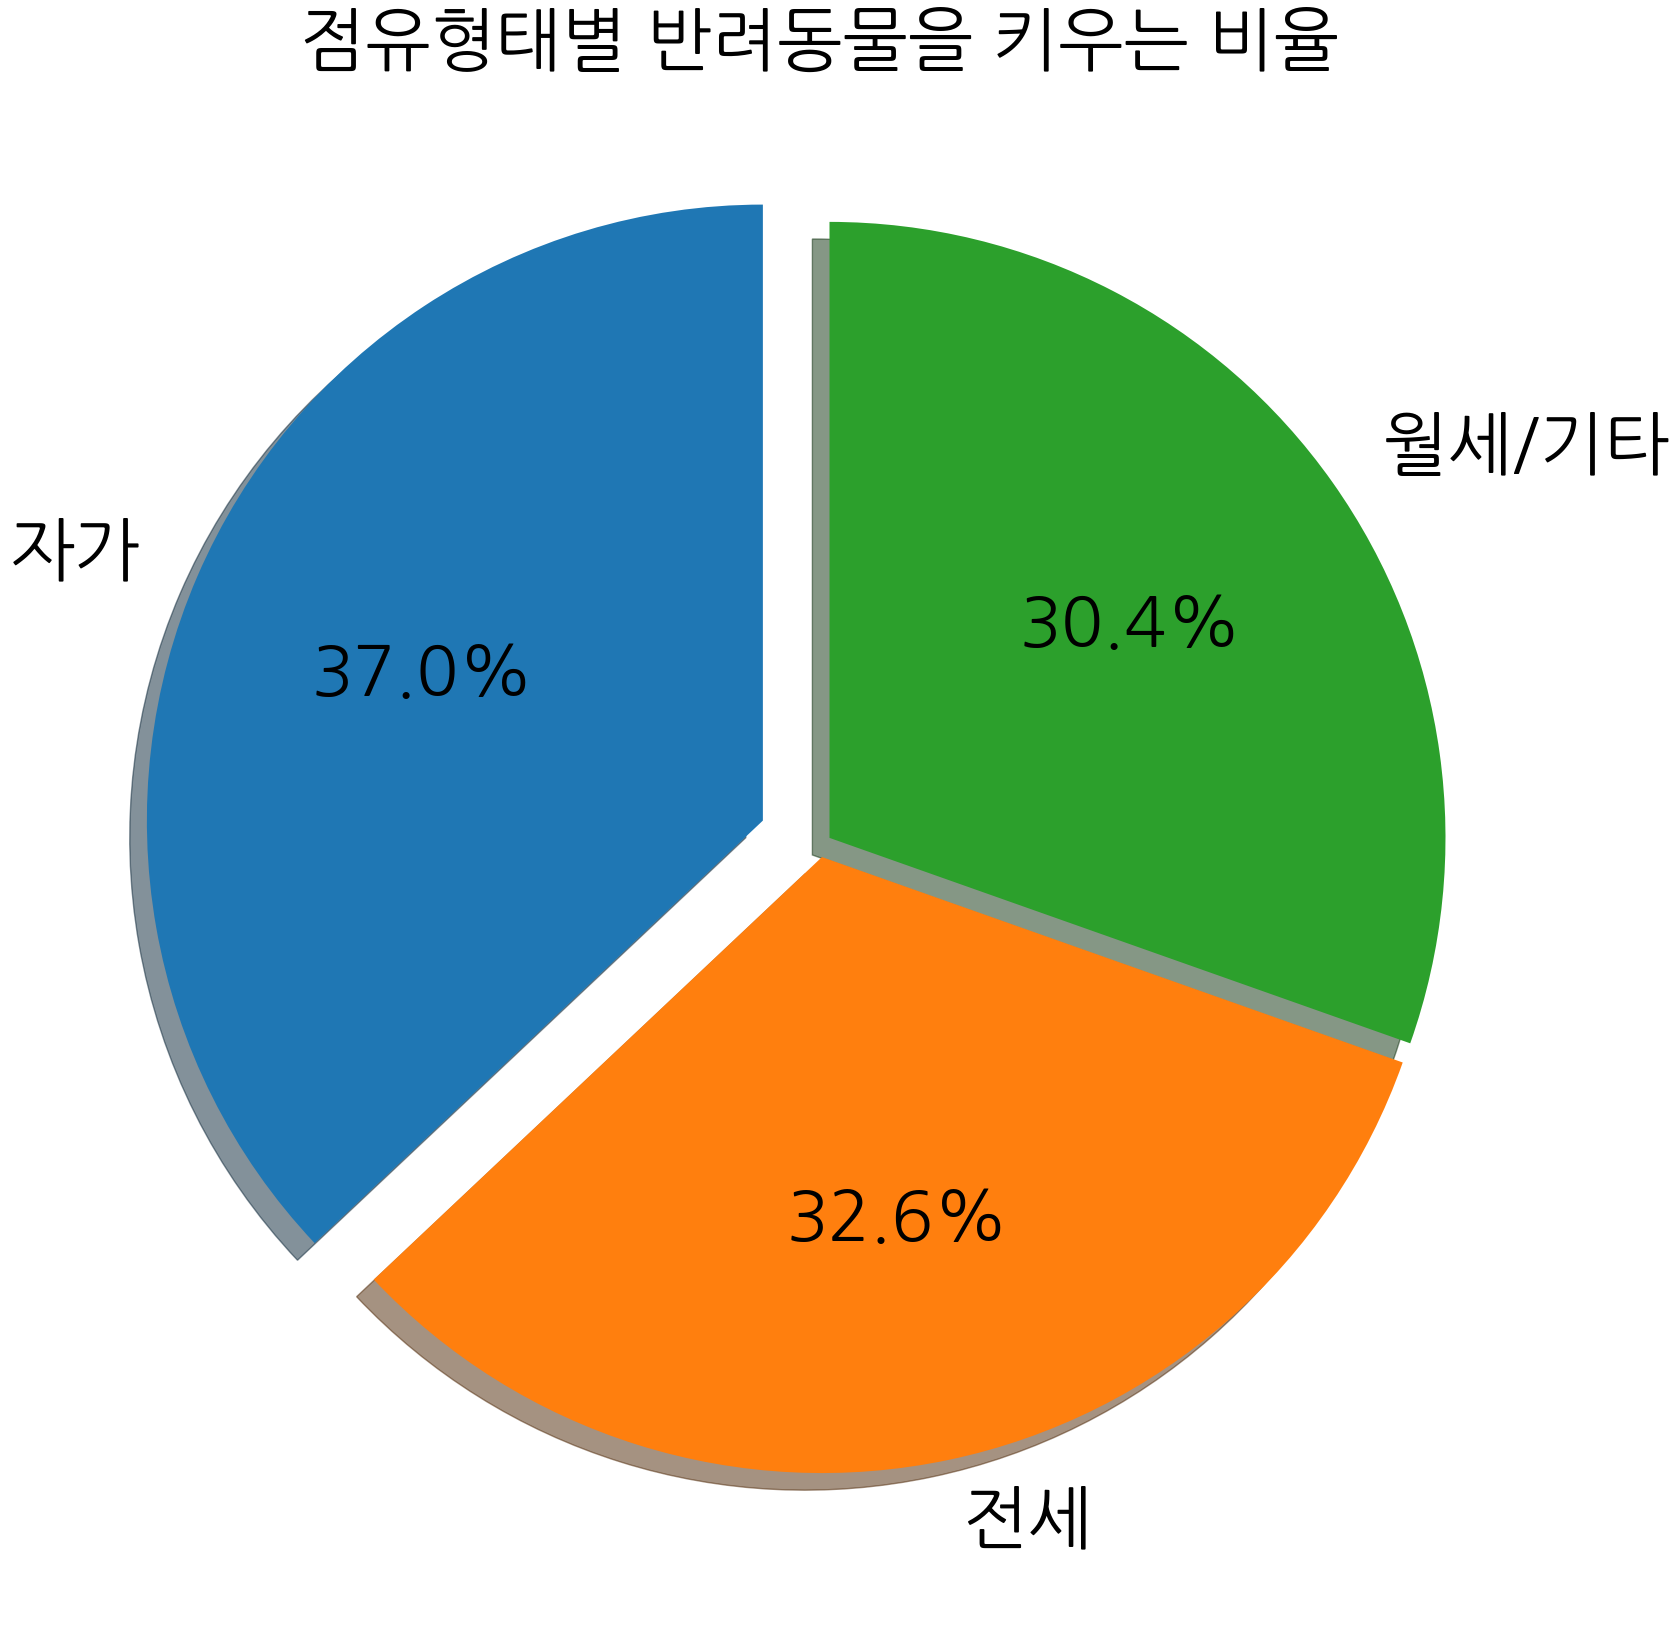

In [18]:
plt.figure(figsize=(20, 20))
plt.pie(property_type["비율"], labels=property_type["형태"], explode=[0.1, 0.02, 0.02], \
        startangle=90, shadow=True, autopct="%1.1f%%", textprops={'fontsize': 50})
plt.title("점유형태별 반려동물을 키우는 비율", fontsize=50)
plt.show()

## 서울시 반려동물 등록 현황

* DB에서 자치구별 총 등록건수 불러오기

In [19]:
query = "select rl.region, sum(rpr.count) as total from region_list rl, region_pet_regist rpr where rl.id = rpr.region_id group by rl.region"
result = db.selectData(query)
region_pet_regist = pd.DataFrame(result, columns=["자치구", "등록수"])
region_pet_regist.head()

,자치구,등록수
0,종로구,10251
1,중구,8600
2,용산구,18676
3,성동구,18346
4,광진구,21875


* 지도 시각화를 위해 타입 변경

In [20]:
region_pet_regist["등록수"] = region_pet_regist["등록수"].astype("int")
region_pet_regist = region_pet_regist.sort_values(by= "등록수", ascending=False)

* folium으로 서울시 자치구별 반려동물 등록수 시각화

In [21]:
geo_path = "../data/skorea_municipalities_geo_simple.json"
geo_str = json.load(open(geo_path, encoding="utf-8"))

map = folium.Map(location=[37.551102, 127], zoom_start=11.3)
folium.Choropleth(
    geo_data=geo_str,
    data=region_pet_regist,
    columns=["자치구", "등록수"],
    key_on="feature.properties.name",
    fill_color="PuRd",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="자치구별 반려동물 등록 수"
).add_to(map)

folium.GeoJson(
    geo_str,
    tooltip=folium.GeoJsonTooltip(fields=["name"], aliases=["지역구:"], localize=True)
).add_to(map)

map

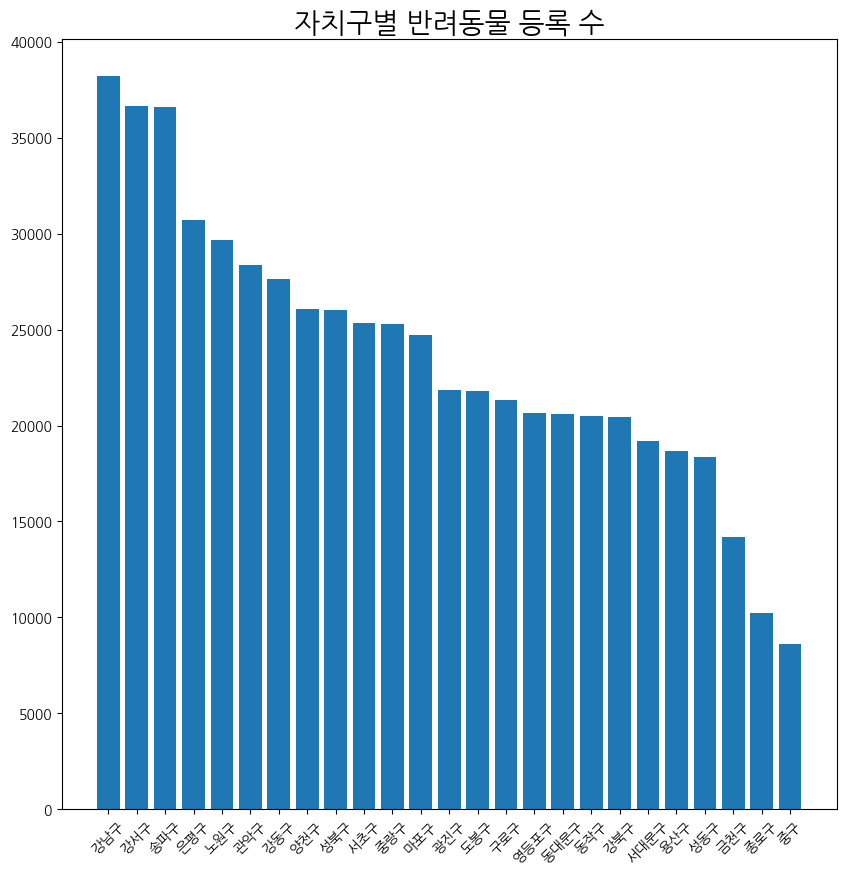

In [35]:
plt.figure(figsize=(10, 10))
plt.bar(region_pet_regist["자치구"], region_pet_regist["등록수"])
plt.title("자치구별 반려동물 등록 수", fontsize=20)
plt.tick_params(axis='x', rotation=45)
plt.show()

## 자치구별 인프라 현황

- ### 동물 전시업 밀집도

In [13]:
sql = """
      SELECT r.region, c.type, p.name, p.lat, p.lng
      FROM pet_infra p
      LEFT JOIN region_list r ON p.region_id = r.id
      LEFT JOIN infra_category c ON p.category_id = c.id
      """
result = db.selectData(sql)

infra_df = pd.DataFrame(result, columns=["region", "category", "name", "lat", "lng"])
infra_df.head()

,region,category,name,lat,lng
0,은평구,공원,은평구 반려견 놀이터,37.490620,126.919205
1,광진구,공원,어린이대공원,37.549362,127.081810
2,마포구,공원,월드컵공원 반려견놀이터,37.563873,126.893501
3,동작구,공원,보라매공원,37.492680,126.919136
4,서초구,공원,매헌시민의숲,37.470684,127.035599


In [14]:
geo_path = "../data/skorea_municipalities_geo_simple.json"
geo_str = json.load(open(geo_path, encoding="utf-8"))

In [16]:
zoo_df = infra_df[infra_df["category"] == "동물전시업"]
region_zoo_data = zoo_df.groupby("region")["category"].count().reset_index()
region_zoo_data.columns = ["region", "zoo_count"]
region_zoo_data = region_zoo_data.set_index("region")

map_center = [infra_df["lat"].mean(), infra_df["lng"].mean()]
m = folium.Map(location=map_center, zoom_start=11)

horopleth = folium.Choropleth(
    geo_data=geo_str,
    data=region_zoo_data,
    columns=[region_zoo_data.index, "zoo_count"],
    key_on="feature.id",
    fill_color="PuRd",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="지역별 동물전시업 수"
).add_to(m)

folium.GeoJson(
    geo_str,
    tooltip=folium.GeoJsonTooltip(
        fields=["name"], 
        aliases=["지역명:"],
        localize=False
    ),
    style_function=lambda x: {
        'fillColor': 'transparent',
        'color': 'transparent',
        'weight': 0 
    }
).add_to(m)
m

- ### 공원 밀집도

In [44]:
park_df = infra_df[infra_df["category"] == "공원"]
region_park_data = park_df.groupby("region")["category"].count().reset_index()
region_park_data.columns = ["region", "park_count"]
region_park_data = region_park_data.set_index("region")

map_center = [infra_df["lat"].mean(), infra_df["lng"].mean()]
m = folium.Map(location=map_center, zoom_start=11)

horopleth = folium.Choropleth(
    geo_data=geo_str,
    data=region_park_data,
    columns=[region_park_data.index, "park_count"],
    key_on="feature.id",
    fill_color="PuRd",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="지역별 공원 수"
).add_to(m)

folium.GeoJson(
    geo_str,
    tooltip=folium.GeoJsonTooltip(
        fields=["name"], 
        aliases=["지역명:"],
        localize=False
    ),
    style_function=lambda x: {
        'fillColor': 'transparent',
        'color': 'transparent',
        'weight': 0 
    }
).add_to(m)
m

- ### 위탁관리업 밀집도

In [37]:
manage_df = infra_df[infra_df["category"] == "동물위탁관리업"]
region_manage_data = manage_df.groupby("region")["category"].count().reset_index()
region_manage_data.columns = ["region", "manage_count"]
region_manage_data = region_manage_data.set_index("region")

map_center = [infra_df["lat"].mean(), infra_df["lng"].mean()]
m = folium.Map(location=map_center, zoom_start=11)

horopleth = folium.Choropleth(
    geo_data=geo_str,
    data=region_manage_data,
    columns=[region_manage_data.index, "manage_count"],
    key_on="feature.id",
    fill_color="PuRd",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="지역별 위탁관리업 수"
).add_to(m)

folium.GeoJson(
    geo_str,
    tooltip=folium.GeoJsonTooltip(
        fields=["name"], 
        aliases=["지역명:"],
        localize=False
    ),
    style_function=lambda x: {
        'fillColor': 'transparent',
        'color': 'transparent',
        'weight': 0 
    }
).add_to(m)
m

- ### 미용업 밀집도

In [38]:
beauty_df = infra_df[infra_df["category"] == "동물미용업"]
region_beauty_df_data = beauty_df.groupby("region")["category"].count().reset_index()
region_beauty_df_data.columns = ["region", "beauty_count"]
region_beauty_df_data = region_beauty_df_data.set_index("region")

map_center = [infra_df["lat"].mean(), infra_df["lng"].mean()]
m = folium.Map(location=map_center, zoom_start=11)

horopleth = folium.Choropleth(
    geo_data=geo_str,
    data=region_beauty_df_data,
    columns=[region_beauty_df_data.index, "beauty_count"],
    key_on="feature.id",
    fill_color="PuRd",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="지역별 미용업 수"
).add_to(m)

folium.GeoJson(
    geo_str,
    tooltip=folium.GeoJsonTooltip(
        fields=["name"], 
        aliases=["지역명:"],
        localize=False
    ),
    style_function=lambda x: {
        'fillColor': 'transparent',
        'color': 'transparent',
        'weight': 0 
    }
).add_to(m)
m